In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation
from keras.layers import LeakyReLU, Multiply, Add
from keras.activations import selu
from keras import backend as K
from keras.optimizers import Adam
import numpy as np

In [2]:
image_dir = '../data/'
images = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]

images[:2]

['../data/3053_2002.jpg', '../data/2732_2002.jpg']

In [13]:
image_size = 64

def preprocess(image):
    # read and convert the image into utf8 tensor
    image = tf.io.read_file(image)

    # decode the image into numpy array tensor
    image = tf.io.decode_jpeg(image)

    # convert the type
    image = tf.cast(image, tf.float32)

    # resize the image
    image = tf.image.resize(image, (image_size, image_size))

    # normalize the image
    image = image / 255.0

    # rehape the image
    image = tf.reshape(image, shape=(image_size, image_size, 3))

    image = tf.expand_dims(image, axis=0)
    
    return image

In [5]:
batch_size = 128

# divide the dataset in batches
training_dataset = tf.data.Dataset.from_tensor_slices((images))

# apply a map function to turn each image in an numpy array tensor
training_dataset = training_dataset.map(preprocess)

# shuffle the dataset and configure to load each batch at a time
training_dataset = training_dataset.shuffle(1000).batch(batch_size)

#
# Hiperparameters

In [6]:
def reconstruction_loss(y, y_pred):
    return tf.reduce_mean(tf.square(y - y_pred))

def kl_loss(mu, log_var):
    return -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))

def var_loss(y, y_pred, mu, log_var):
    return reconstruction_loss(y, y_pred) + (1 / (64 * 64)) * kl_loss(mu, log_var)

#
# Model

In [7]:
K.clear_session()
latent_dim = 512


## ENCODER
encoder_input = Input(shape=(64, 64, 3))
x = Conv2D(32, kernel_size=5, activation=LeakyReLU(0.02), strides=1, padding='same')(encoder_input)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=5, activation=LeakyReLU(0.02), strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, kernel_size=5, activation=LeakyReLU(0.02), strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(256, kernel_size=5, activation=LeakyReLU(0.02), strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(512, kernel_size=5, activation=LeakyReLU(0.02), strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(1024, activation=selu)(x)


## LATENT
encoder_output = BatchNormalization()(x)

mu = Dense(latent_dim)(encoder_output)
log_var = Dense(latent_dim)(encoder_output)

epsilon = K.random_normal(shape=(tf.shape(mu)[0], tf.shape(mu)[1]))
sigma = tf.exp(0.5 * log_var)

z_eps = Multiply()([sigma, epsilon])
z = Add()([mu, z_eps])

encoder = Model(encoder_input, outputs=[mu, log_var, z], name='encoder')


## DECODER
decoder = Sequential()
decoder.add(Dense(1024, activation=selu, input_shape=(latent_dim,)))
decoder.add(BatchNormalization())

decoder.add(Dense(8192, activation=selu))
decoder.add(Reshape((4, 4, 512)))

decoder.add(Conv2DTranspose(256, (5, 5), activation=LeakyReLU(0.02), strides=2, padding='same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(128, (5, 5), activation=LeakyReLU(0.02), strides=2, padding='same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(64, (5, 5), activation=LeakyReLU(0.02), strides=2, padding='same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(32, (5, 5), activation=LeakyReLU(0.02), strides=2, padding='same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(3, (5, 5), activation='sigmoid', strides=1, padding='same'))
decoder.add(BatchNormalization())


## CONNECT ENCODER AND DECODER
mu, log_var, z = encoder(encoder_input)
reconstructed = decoder(z)
model = Model(encoder_input, reconstructed, name='Variational Autoencoder')
loss = kl_loss(mu, log_var)
model.add_loss(loss)
model.summary()

Model: "Variational Autoencoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 512),                1380268   ['input_1[0][0]']             
                              (None, 512),                8                                       
                              (None, 512)]                                                        
                                                                                                  
 sequential (Sequential)     (None, 64, 64, 3)            1328302   ['encoder[0][2]']             
                                                          3                 

(64, 64, 3)


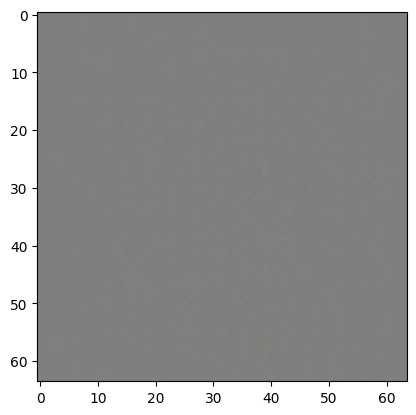

In [35]:
img = (model(preprocess(images[0])) * 255.0)[0].numpy().astype(int)

print(img.shape)
plt.imshow(img)
plt.show()

#
# Saving images during training

In [8]:
def save_images(model, epoch, step, input_):
    prediction = model.predict(input_)
    fig, axes = plt.subplots(5, 5, figsize=(14, 14))
    idx = 0
    for row in range(5):
        for column in range(5):
            image = prediction[idx] * 255
            image = image.astype('int32')
            axes[row, column].imshow(image)
            axes[row, column].axis('off')
            idx += 1
    output_path = 'output/'

    if not os.path.exists(output_path):
        os.mkdir(output_path)
    plt.savefig(output_path + 'Epoch_{:04d}_step_{:04d}.jpg'.format(epoch, step))
    plt.close()

#
# Train

In [9]:
random_vector = tf.random.normal(shape=(25, latent_dim))
save_images(decoder, 0, 0, random_vector)

mse_losses = []
kl_losses = []

optimizer = Adam(0.0001, 0.5)
epochs = 100

for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    for step, training_batch in enumerate(training_dataset):
        with tf.GradientTape() as tape:
            reconstructed = model(training_batch)
            y_true = tf.reshape(training_batch, shape = [-1])
            y_pred = tf.reshape(reconstructed, shape = [-1])
            
            mse_loss = reconstruction_loss(y_true, y_pred)
            mse_losses.append(mse_loss.numpy())
            
            kl = sum(model.losses)
            kl_losses.append(kl.numpy())
            
            train_loss = 0.01 * kl + mse_loss
            
            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            if step % 10 == 0:
                save_images(decoder, epoch, step, random_vector)
            print('Epoch: %s - Step: %s - MSE loss: %s - KL loss: %s' % (epoch, step, mse_loss.numpy(), kl.numpy()))

1/1 [==============================] - 0s 414ms/step
Epoch:  1
1/1 [==============================] - 0s 92ms/step
Epoch: 1 - Step: 0 - MSE loss: 0.09589151 - KL loss: 0.001586138
Epoch: 1 - Step: 1 - MSE loss: 0.097878836 - KL loss: 0.0011765136
Epoch: 1 - Step: 2 - MSE loss: 0.09153416 - KL loss: 0.000850165
Epoch: 1 - Step: 3 - MSE loss: 0.0963415 - KL loss: 0.0006176908
Epoch:  2
1/1 [==============================] - 0s 94ms/step
Epoch: 2 - Step: 0 - MSE loss: 0.09324068 - KL loss: 0.0004650008
Epoch: 2 - Step: 1 - MSE loss: 0.0940694 - KL loss: 0.0003600206
Epoch: 2 - Step: 2 - MSE loss: 0.09505423 - KL loss: 0.00030459225
Epoch: 2 - Step: 3 - MSE loss: 0.09641608 - KL loss: 0.00025694072
Epoch:  3
1/1 [==============================] - 0s 103ms/step
Epoch: 3 - Step: 0 - MSE loss: 0.09437666 - KL loss: 0.00022980309
Epoch: 3 - Step: 1 - MSE loss: 0.09294041 - KL loss: 0.000219222
Epoch: 3 - Step: 2 - MSE loss: 0.094076864 - KL loss: 0.00022582771
Epoch: 3 - Step: 3 - MSE loss: 0.